<a href="https://colab.research.google.com/github/MishkaDewlok/PDAN812_PART2/blob/main/PDAN8412_POE_PART2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mishka Dewlok

ST10219921

PDAN8412 POE - PART 2

Dataset sourced from Kaggle at: https://www.kaggle.com/datasets/asaniczka/amazon-kindle-books-dataset-2023-130k-books

**Setup:**
This section sets up the environment to work with Kaggle datasets and PySpark to use for analysis as needed. It installs the necessary packages (kaggle, pyspark and pyarrow) and suppresses any warnings to keep the output clean. It then prompts to upload the kaggle.json file, which contains the Kaggle API credentials to find and connect to the dataset being used off of kaggle. The code then saves and secures the key in the correct directory so that the dataset can be accessed. After authentication, it downloads the Amazon Kindle Books Dataset (2023) from Kaggle, extracts the files and lists the available files to confirm that the dataset has been successfully loaded.

In [1]:

#Setup: Kaggle + PySpark
!pip -q install kaggle pyspark pyarrow==16.1.0

import os, json, zipfile, glob, shutil, warnings
warnings.filterwarnings("ignore")

# Upload the kaggle.json
from google.colab import files
import os

print("Please upload kaggle.json")
uploaded = files.upload()

# handle alternate names like "kaggle (1).json"
kaggle_file = None
for name in uploaded.keys():
    if name.endswith(".json"):
        kaggle_file = name
        break
if kaggle_file is None:
    raise FileNotFoundError("No .json file uploaded.")

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "wb") as f:
    f.write(uploaded[kaggle_file])
os.chmod("/root/.kaggle/kaggle.json", 0o600)
print("kaggle.json installed to /root/.kaggle")

# Download the dataset from Kaggle
DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

!kaggle datasets download -d asaniczka/amazon-kindle-books-dataset-2023-130k-books -p {DATA_DIR}
# Unzip everything inside DATA_DIR
for z in glob.glob(os.path.join(DATA_DIR, "*.zip")):
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

print("Files in /content/data :")
print("\n".join(sorted(os.listdir(DATA_DIR))))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.2 MB/s eta 0:00:00
Please upload kaggle.json


Saving kaggle.json to kaggle.json
kaggle.json installed to /root/.kaggle
Dataset URL: https://www.kaggle.com/datasets/asaniczka/amazon-kindle-books-dataset-2023-130k-books
License(s): ODC Attribution License (ODC-By)
  0% 0.00/9.11M [00:00<?, ?B/s]
100% 9.11M/9.11M [00:00<00:00, 1.43GB/s]
Files in /content/data :
amazon-kindle-books-dataset-2023-130k-books.zip
kindle_data-v2.csv


Use of Spark for Analysis:

This section starts a Spark session and loads the dataset into a PySpark DataFrame for further analysis. It first creates a Spark environment named "KindleBooks-EDA-Prep" and sets configuration options to optimise performance. The code then searches the data directory for any CSV files extracted from the Kaggle downloaded dataset. Once it finds one, it loads the CSV file into Spark with headers and automatically sees the data types of each column. Finally, it displays the total number of rows, prints the schema showing column names and data types and previews the first few rows of the dataset to confirm that it has been successfully loaded.

In [2]:
# Start Spark + Load CSV FILES

#Selvaraj, N. (2022).
#Pyspark Tutorial: Getting Started with Pyspark. [online] Datacamp.com.
#Available at: https://www.datacamp.com/tutorial/pyspark-tutorial-getting-started-with-pyspark.
#Date Accessed: 25 October 2025
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T

spark = SparkSession.builder \
    .appName("KindleBooks-EDA-Prep") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

# Find a CSV in the folder
csv_candidates = [p for p in glob.glob(os.path.join(DATA_DIR, "**/*.csv"), recursive=True)]
if not csv_candidates:
    raise FileNotFoundError("No CSV files found after unzip. Inspect DATA_DIR and adjust path.")
CSV_PATH = csv_candidates[0]
print("Loading CSV:", CSV_PATH)

df_raw = spark.read.option("header", True).option("inferSchema", True).csv(CSV_PATH)
print("Row count:", df_raw.count())
df_raw.printSchema()
df_raw.show(5, truncate=80)


Loading CSV: /content/data/kindle_data-v2.csv
Row count: 133102
root
 |-- asin: string (nullable = true)
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- soldBy: string (nullable = true)
 |-- imgUrl: string (nullable = true)
 |-- productURL: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- price: string (nullable = true)
 |-- isKindleUnlimited: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- isBestSeller: string (nullable = true)
 |-- isEditorsPick: string (nullable = true)
 |-- isGoodReadsChoice: string (nullable = true)
 |-- publishedDate: string (nullable = true)
 |-- category_name: string (nullable = true)

+----------+--------------------------------------------------------------------------------+-----------------+------------------------+--------------------------------------------------------------+------------------------------------+-----+-------+-----+------------

**Exploratory Data Analysis (EDA):** This section begins the EDA (Exploratory Data Analysis) by starting the data cleaning and data preprocessing steps. first cleaning and preparing the dataset. It standardises all column names into a consistent snake_case format, making them easier to reference in later steps. After renaming the columns, the code prints the updated column list and generates some quick summary statistics including the total number of rows, and how many unique titles and authors are present. It then calculates and displays the number of missing (null or NaN) values in each column, helping to identify data quality issues that may need cleaning before further analysis.

In [3]:
# 2) Clean columns + light EDA

# Mungingdata.com. (2025).
#select and add columns in PySpark - MungingData. [online]
#Available at: https://www.mungingdata.com/pyspark/select-add-columns-withcolumn/
#[Date Accessed: 25 October 2025]

# Normalise column names to snake_case
def to_snake(s):
    return (
        s.lower()
        .replace(" ", "_")
        .replace("-", "_")
        .replace("/", "_")
        .replace("(", "")
        .replace(")", "")
        .replace(".", "_")
        .replace("__", "_")
        .strip("_")
    )

for old, new in [(c, to_snake(c)) for c in df_raw.columns]:
    if old != new:
        df_raw = df_raw.withColumnRenamed(old, new)

print("Columns:", df_raw.columns)

# some summaries using Spark EDA
print("Total rows:", df_raw.count())
print("Distinct titles:", df_raw.select(F.col("title")).distinct().count() if "title" in df_raw.columns else "n/a")
print("Distinct authors:", df_raw.select(F.col("author")).distinct().count() if "author" in df_raw.columns else "n/a")

# Show NA counts per column (top 30 columns)
na_counts = (
    df_raw.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c)).alias(c) for c in df_raw.columns])
    .toPandas().T
)
display(na_counts.head(30))

Columns: ['asin', 'title', 'author', 'soldby', 'imgurl', 'producturl', 'stars', 'reviews', 'price', 'iskindleunlimited', 'category_id', 'isbestseller', 'iseditorspick', 'isgoodreadschoice', 'publisheddate', 'category_name']
Total rows: 133102
Distinct titles: 131913
Distinct authors: 72848


,0
asin,0
title,0
author,425
soldby,9229
imgurl,1
producturl,3
stars,0
reviews,0
price,0
iskindleunlimited,0


**Feature Selection:** This section builds features ready for training from the raw books data. It turns price, rating and review counts to numeric types, parses publication year and creates author popularity and a primary genre. It then selects useful signals such as price bands, author popularity quintiles, a high rating flag and others. A binary target label is derived from isbestseller to use in determining whether the book will be a best seller. Finally, it cuts to a focused feature set, checks the class balance and applies sanity filters to keep values in appropriate ranges.

In [4]:
# Feature Selecton
from pyspark.sql import functions as F, types as T
from pyspark.sql.window import Window

df = df_raw

# Cast key fields to numeric
#Gibson, K. (2023).
#Casting Data Types in PySpark. [online] Medium.
#Available at: https://datamadness.medium.com/casting-data-types-in-pyspark-f95d1326449b
#[Date Accessed: 25 October 2025].

df = df.withColumn("price_num", F.col("price").cast("double"))
df = df.withColumn("rating_num", F.col("stars").cast("double"))
df = df.withColumn("review_count_num", F.col("reviews").cast("double"))

# Get publication year
if "publisheddate" in df.columns:
    df = df.withColumn("pub_ts", F.to_timestamp("publisheddate"))
    df = df.withColumn("pub_year",
                       F.when(F.col("pub_ts").isNotNull(), F.year("pub_ts"))
                        .otherwise(F.lit(None).cast("int")))
else:
    df = df.withColumn("pub_year", F.lit(None).cast("int"))

# Author popularity (total reviews per author)
if "author" in df.columns and "review_count_num" in df.columns:
    author_pop = (df.groupBy("author")
                    .agg(F.sum("review_count_num").alias("author_total_reviews")))
    df = df.join(author_pop, on="author", how="left")
else:
    df = df.withColumn("author_total_reviews", F.lit(None).cast("double"))

# Primary genre from category_name
if "category_name" in df.columns:
    df = df.withColumn(
        "primary_genre",
        F.trim(F.split(F.col("category_name"), r"[|,;/]").getItem(0))
    )
else:
    df = df.withColumn("primary_genre", F.lit(None).cast("string"))


# Price categories
df = df.withColumn("price_category",
    F.when(F.col("price_num") < 5, "low")
     .when(F.col("price_num") < 15, "medium")
     .otherwise("high"))

# Author popularity
w = Window.orderBy(F.col("author_total_reviews").asc_nulls_first())
df = df.withColumn("author_popularity_quintile",
    F.ntile(5).over(w))

# High rating
df = df.withColumn("high_rating",
    F.when(F.col("rating_num") >= 4.5, 1).otherwise(0))

# Recency features
df = df.withColumn("years_since_pub",
    F.lit(2023) - F.col("pub_year"))
df = df.withColumn("is_recent",
    F.when(F.col("years_since_pub") <= 2, 1).otherwise(0))

# Log reviews
#spark.apache.org. (n.d.).
#Extracting, transforming and selecting features - Spark 3.5.1 Documentation. [online]
#Available at: https://spark.apache.org/docs/latest/ml-features.html.
#[Date Accessed: 25 October 2025]
df = df.withColumn("log_reviews",
    F.when(F.col("review_count_num") > 0,
           F.log1p(F.col("review_count_num")))
     .otherwise(0))

# Target Label: use isbestseller
def to_label():
    return (F.when(
                F.lower(F.col("isbestseller").cast("string")).isin("1","true","yes","y"),
                F.lit(1)
            )
            .otherwise(F.lit(0)))

if "isbestseller" in df.columns:
    df = df.withColumn("label", to_label())
else:
    raise RuntimeError("Expected 'isbestseller' column not found.")

# Keep working set with new features
keep_cols = ["title", "author", "price_num", "rating_num", "review_count_num",
             "pub_year", "author_total_reviews", "primary_genre",
             "price_category", "author_popularity_quintile", "high_rating",
             "years_since_pub", "is_recent", "log_reviews", "label"]
keep_cols = [c for c in keep_cols if c in df.columns]
df_work = df.select(*keep_cols)

print("Working columns:", df_work.columns)

# Check class balance
print("Class balance (label):")
df_work.groupBy("label").count().orderBy("label").show()

# Sanity filters
cond = F.lit(True)
if "price_num" in df_work.columns:
    cond = cond & ((F.col("price_num").isNull()) | ((F.col("price_num") >= 0) & (F.col("price_num") <= 2000)))
if "rating_num" in df_work.columns:
    cond = cond & ((F.col("rating_num").isNull()) | ((F.col("rating_num") >= 0) & (F.col("rating_num") <= 5)))
if "review_count_num" in df_work.columns:
    cond = cond & ((F.col("review_count_num").isNull()) | (F.col("review_count_num") >= 0))

df_work = df_work.where(cond)
print("Rows after sanity filters:", df_work.count())
df_work.show(5, truncate=80)

Working columns: ['title', 'author', 'price_num', 'rating_num', 'review_count_num', 'pub_year', 'author_total_reviews', 'primary_genre', 'price_category', 'author_popularity_quintile', 'high_rating', 'years_since_pub', 'is_recent', 'log_reviews', 'label']
Class balance (label):
+-----+------+
|label| count|
+-----+------+
|    0|130858|
|    1|  2244|
+-----+------+

Rows after sanity filters: 133102
+--------------------------------------------------------------------------------+---------+---------+----------+----------------+--------+--------------------+-------------------------+--------------+--------------------------+-----------+---------------+---------+-----------+-----+
|                                                                           title|   author|price_num|rating_num|review_count_num|pub_year|author_total_reviews|            primary_genre|price_category|author_popularity_quintile|high_rating|years_since_pub|is_recent|log_reviews|label|
+-------------------------

**Feature Encoding:** This section prepares the final dataset for learning by encoding categorical features and building the modelling DataFrame. It first limits the number of unique genres to the top 30 most frequent ones to reduce high cardinality and replaces the rest with “Other.” The key categorical columns (primary_genre_limited and price_category) are then transformed into numerical form using StringIndexer and OneHotEncoder. Numeric features such as price, rating and author statistics are combined with these encoded columns to form the final Spark DataFrame (df_model_spark), which will be ready for model training and evaluation.

In [5]:
#Encode categorical + final Spark frame

from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Limit genres to top 30
cat_cols = []
if "primary_genre" in df_work.columns:
    genre_counts = df_work.groupBy("primary_genre").count().orderBy(F.desc("count"))
    top_genres = [r["primary_genre"] for r in genre_counts.limit(30).collect() if r["primary_genre"]]
    df_work = df_work.withColumn(
        "primary_genre_limited",
        F.when(F.col("primary_genre").isin(top_genres), F.col("primary_genre")).otherwise(F.lit("Other"))
    )
    cat_cols.append("primary_genre_limited")

# Add price_category to categorical
if "price_category" in df_work.columns:
    cat_cols.append("price_category")

# Encode categorical columns with StringIndexer + OneHotEncoder
#Trainindata.com. (2018).
#Categorical Encoding — 1.8.2. [online]
#Available at: https://feature-engine.trainindata.com/en/1.8.x/user_guide/encoding/index.html.
#[Date Accessed: 26 October 2025]
encoded_cols = []
for c in cat_cols:
    idx = c + "_idx"
    ohe = c + "_ohe"
    indexer = StringIndexer(inputCol=c, outputCol=idx, handleInvalid="keep")
    df_work = indexer.fit(df_work).transform(df_work)
    encoder = OneHotEncoder(inputCols=[idx], outputCols=[ohe], handleInvalid="keep")
    df_work = encoder.fit(df_work).transform(df_work)
    encoded_cols.append(ohe)

# Numeric feature columns to keep
num_cols = ["price_num", "rating_num", "review_count_num", "pub_year",
            "author_total_reviews", "author_popularity_quintile", "high_rating",
            "years_since_pub", "is_recent", "log_reviews"]
num_cols = [c for c in num_cols if c in df_work.columns]

#ombine label, numeric and encoded features
final_cols = ["label"] + num_cols + encoded_cols
df_model_spark = df_work.select(*final_cols).na.drop(subset=["label"])

#Display summary info
print("Final Spark columns:", df_model_spark.columns)
print("Final Spark rows:", df_model_spark.count())
df_model_spark.show(3, truncate=False)

Final Spark columns: ['label', 'price_num', 'rating_num', 'review_count_num', 'pub_year', 'author_total_reviews', 'author_popularity_quintile', 'high_rating', 'years_since_pub', 'is_recent', 'log_reviews', 'primary_genre_limited_ohe', 'price_category_ohe']
Final Spark rows: 133102
+-----+---------+----------+----------------+--------+--------------------+--------------------------+-----------+---------------+---------+-----------+-------------------------+------------------+
|label|price_num|rating_num|review_count_num|pub_year|author_total_reviews|author_popularity_quintile|high_rating|years_since_pub|is_recent|log_reviews|primary_genre_limited_ohe|price_category_ohe|
+-----+---------+----------+----------------+--------+--------------------+--------------------------+-----------+---------------+---------+-----------+-------------------------+------------------+
|0    |4.2      |NULL      |NULL            |NULL    |NULL                |1                         |0          |NULL      

**Convert to Pandas:** This section converts the processed Spark DataFrame into a Pandas format and prepares the data for machine learning. It separates the target variable (label) from the features and expands the one hot encoded Spark vectors into NumPy arrays. Numeric features are standardised using StandardScaler to ensure they aree on the same scale. The dataset is then split into training and testing sets using train_test_split. To handle class imbalance, the majority class (non-bestsellers) is undersampled to create a roughly 3:1 ratio between negative and positive classes. The final balanced training set is shuffled and ready for model training.

In [6]:
#Move to Pandas + Create balanced dataset

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Convert Spark DataFrame to Pandas
pdf = df_model_spark.toPandas()
y = pdf["label"].astype(int).values.reshape(-1, 1)

#Convert Spark vector columns to NumPy array
#Komali (2021).
#Convert Pandas DataFrame to NumPy Array. [online] Spark By {Examples}.
#Available at: https://sparkbyexamples.com/pandas/convert-pandas-dataframe-to-numpy-array/
#[Date Accessed: 26 October 2025].
def expand_vector_col(series):
    dense_list = []
    for v in series:
        if v is None:
            dense_list.append(None)
        else:
            try:
                dense_list.append(np.array(v.toArray()))
            except Exception:
                dense_list.append(np.array([v], dtype=float))
    return np.vstack(dense_list)

#Extract numeric columns
num_cols_in_pdf = [c for c in pdf.columns if c in num_cols]
X_num = pdf[num_cols_in_pdf].copy() if num_cols_in_pdf else pd.DataFrame(index=pdf.index)

#Combine numeric and one-hot encoded features
X_blocks = []
if not X_num.empty:
    X_blocks.append(X_num.values)

for c in [col for col in pdf.columns if col.endswith("_ohe")]:
    block = expand_vector_col(pdf[c])
    X_blocks.append(block)

X = np.hstack([b for b in X_blocks if b is not None])

#standardise values
if not X_num.empty:
    scaler = StandardScaler()
    X[:, :X_num.shape[1]] = scaler.fit_transform(X[:, :X_num.shape[1]])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Original X shape:", X.shape)
print("Original Train:", X_train.shape, "Test:", X_test.shape)
print("Original positive class share (train):", y_train.mean(), " (test):", y_test.mean())

# Separate positive and negative samples
X_train_pos = X_train[y_train.flatten() == 1]
y_train_pos = y_train[y_train.flatten() == 1]
X_train_neg = X_train[y_train.flatten() == 0]
y_train_neg = y_train[y_train.flatten() == 0]

print(f"\nOriginal training: {len(X_train_pos)} positive, {len(X_train_neg)} negative")

# Randomly reduce majority class (undersampling)
#Trotta, F. (2024).
#How to Handle Imbalanced Data for Machine Learning in Python - Semaphore. [online] Semaphore.
#Available at: https://semaphore.io/blog/imbalanced-data-machine-learning-python.
#[Date Accessed: 26 October 2025]
neg_size = len(X_train_pos) * 3
np.random.seed(42)
neg_indices = np.random.choice(len(X_train_neg), min(neg_size, len(X_train_neg)), replace=False)
X_train_neg_sampled = X_train_neg[neg_indices]
y_train_neg_sampled = y_train_neg[neg_indices]

# Combine positives and sampled negatives
X_train = np.vstack([X_train_pos, X_train_neg_sampled])
y_train = np.vstack([y_train_pos, y_train_neg_sampled])

# Shuffle training data
shuffle_idx = np.random.permutation(len(X_train))
X_train = X_train[shuffle_idx]
y_train = y_train[shuffle_idx]

#display final balance info
print(f"Resampled training: {len(X_train)} total, {y_train.sum():.0f} positive")
print(f"New training balance: {y_train.mean():.3f} positive class share")
print(f"Balanced Train shape: {X_train.shape}")

Original X shape: (133102, 46)
Original Train: (106481, 46) Test: (26621, 46)
Original positive class share (train): 0.016857467529418396  (test): 0.01686638368205552

Original training: 1795 positive, 104686 negative
Resampled training: 7180 total, 1795 positive
New training balance: 0.250 positive class share
Balanced Train shape: (7180, 46)


**Logistic Regression from scratch:** This section implements Logistic Regression from scratch using only NumPy. The class defines all the core parts of the algorithm manually including the sigmoid activation, loss function, gradient descent updates and L2 regularisation. It trains the model by iteratively adjusting weights to minimise the loss between predicted and actual labels. The code also includes methods to make predictions, compute probabilities and calculate the Wald statistics which include the standard errors, z-scores and p-values, for evaluating feature significance. This helps illustrate how logistic regression works internally without relying on scikit-learn.

In [7]:
#Logistic Regression from scratch
#narendrageek (2020).
#Understand the Logistic regression from Scratch. [online] Kaggle.com.
#Available at: https://www.kaggle.com/code/narendrageek/understand-the-logistic-regression-from-scratch.
#[Date Accessed: 26 October 2025]
import numpy as np
from scipy.stats import norm

class LogisticRegressionScratch:
    def __init__(self, lr=0.1, n_iter=4000, l2=1.0, fit_intercept=True, tol=1e-8, verbose=False):
        self.lr = lr
        self.n_iter = n_iter
        self.l2 = l2
        self.fit_intercept = fit_intercept
        self.tol = tol
        self.verbose = verbose
        self.loss_history_ = []

    @staticmethod
    def _sigmoid(z):
        """Numerically stable sigmoid function"""
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def _add_intercept(self, X):
        if not self.fit_intercept:
            return X
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def fit(self, X, y):
        # Clean input from NaN or infinity
        if np.any(np.isnan(X)) or np.any(np.isinf(X)):
            print("WARNING: NaN/Inf detected in X, cleaning...")
            X = np.nan_to_num(X, nan=0.0, posinf=1e10, neginf=-1e10)

        if np.any(np.isnan(y)) or np.any(np.isinf(y)):
            raise ValueError("NaN/Inf detected in y labels!")

        Xb = self._add_intercept(X)
        n, d = Xb.shape
        y = y.reshape(-1, 1)

        # Initialise weights randomly with random values
        #colinfang (2016).
        #logistic / sigmoid function implementation numerical precision. [online] Stack Overflow.
        #Available at: https://stackoverflow.com/questions/37074566/logistic-sigmoid-function-implementation-numerical-precision.
        #[Date Accessed: 26 October 2025]
        np.random.seed(42)
        self.w_ = np.random.randn(d, 1) * 0.01

        prev = np.inf
        for i in range(self.n_iter):
            z = Xb @ self.w_

            # avoid overflow
            z = np.clip(z, -500, 500)

            p = self._sigmoid(z)

            #prevent log(0)
            p = np.clip(p, 1e-12, 1 - 1e-12)

            eps = 1e-12
            loss = (- (y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))).mean()

            # Add L2 regularization
            if self.fit_intercept:
                loss += (self.l2/(2*n)) * np.sum(self.w_[1:]**2)
            else:
                loss += (self.l2/(2*n)) * np.sum(self.w_**2)

            # Stop if loss becomes invalid
            if np.isnan(loss) or np.isinf(loss):
                print(f"WARNING: Loss became NaN/Inf at iteration {i}, stopping early")
                break

            self.loss_history_.append(float(loss))

            # Compute gradient
            grad = (Xb.T @ (p - y)) / n

            # Add L2 gradient
            if self.fit_intercept:
                grad[1:] += (self.l2 / n) * self.w_[1:]
            else:
                grad += (self.l2 / n) * self.w_

            # Clip gradient to prevent explosion
            grad = np.clip(grad, -10, 10)

            self.w_ -= self.lr * grad

            # Stop early if change in loss is small
            if abs(prev - loss) < self.tol:
                if self.verbose:
                    print(f"Converged at iteration {i}")
                break
            prev = loss

            #Print progress occasionally
            if self.verbose and i % 500 == 0:
                print(f"Iter {i}, Loss: {loss:.6f}")

        self.coef_ = self.w_[1:].T if self.fit_intercept else self.w_.T
        self.intercept_ = float(self.w_[0]) if self.fit_intercept else 0.0
        return self

    def predict_proba(self, X):
        # Return predicted probabilities
        if np.any(np.isnan(X)) or np.any(np.isinf(X)):
            print("WARNING: NaN/Inf in prediction input, cleaning...")
            X = np.nan_to_num(X, nan=0.0, posinf=1e10, neginf=-1e10)

        Xb = self._add_intercept(X)
        z = Xb @ self.w_
        z = np.clip(z, -500, 500)
        proba = self._sigmoid(z)

        # Ensure valid probabilities
        proba = np.clip(proba, 0.0, 1.0)
        return proba

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

    def wald_pvalues(self, X, y):
        Xb = self._add_intercept(X)
        p = self._sigmoid(Xb @ self.w_)
        W = (p * (1 - p)).flatten()
        W = np.clip(W, 1e-10, None)
        Xw = Xb * W.reshape(-1, 1)
        H = Xb.T @ Xw
        try:
            H_inv = np.linalg.inv(H)
        except np.linalg.LinAlgError:
            H_inv = np.linalg.pinv(H)
        se = np.sqrt(np.diag(H_inv)).reshape(-1, 1)
        z = self.w_ / (se + 1e-12)
        p_vals = 2 * (1 - norm.cdf(np.abs(z)))
        return se.flatten(), z.flatten(), p_vals.flatten()

**Hyperparameter tuning:** This section performs hyperparameter tuning for the custom logistic regression model to find the best learning rate (lr) and regularisation strength (l2). It splits the training data again into a training and validation set, then trains the model with different combinations of these parameters. For each model, it checks multiple threshold values to find the one that gives the highest F1 score, which balances precision and recall. After testing all combinations, it reports the best performing hyperparameters based on validation results.

In [8]:
# Hyperparameter tuning with better parameters
#GeeksforGeeks (2024).
#How to Optimize Logistic Regression Performance. [online] GeeksforGeeks.
#Available at: https://www.geeksforgeeks.org/machine-learning/how-to-optimize-logistic-regression-performance/.
#[Date Accessed: 26 October 2025]
from sklearn.metrics import f1_score

# Build feature names
feature_names = []
feature_names += [f"num_{i}" for i in range(len(num_cols_in_pdf))]
ohe_cols = [c for c in pdf.columns if c.endswith("_ohe")]
for c in ohe_cols:
    w = len(pdf[c].iloc[0].toArray()) if hasattr(pdf[c].iloc[0], "toArray") else 1
    feature_names += [f"{c}_{j}" for j in range(w)]

# Train/validation split for tuning
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=7, stratify=y_train
)

# Better hyperparameter range
lrs = [0.01, 0.05, 0.1]
l2s = [0.01, 0.1, 0.5, 1.0]

best_cfg = None
best_score = -1.0

print("Starting hyperparameter search...")

#Loop over all parameter combinations
for lr in lrs:
    for l2 in l2s:
        hp = dict(lr=lr, n_iter=6000, l2=l2, fit_intercept=True, tol=1e-8, verbose=False)
        mdl = LogisticRegressionScratch(**hp).fit(X_tr, y_tr)
        val_proba = mdl.predict_proba(X_val).flatten()

        # Find best threshold for F1
        best_f1 = 0
        for thresh in np.linspace(0.1, 0.5, 41):
            y_pred = (val_proba >= thresh).astype(int)
            f1 = f1_score(y_val, y_pred, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1

        print(f"  lr={lr:.3f}, l2={l2:.2f} -> best val F1={best_f1:.4f}")

        #save
        if best_f1 > best_score:
            best_score = best_f1
            best_cfg = hp

#print
print(f"\nBest hyperparams: {best_cfg} (val F1={best_score:.4f})")

Starting hyperparameter search...
  lr=0.010, l2=0.01 -> best val F1=0.4848
  lr=0.010, l2=0.10 -> best val F1=0.4848
  lr=0.010, l2=0.50 -> best val F1=0.4848
  lr=0.010, l2=1.00 -> best val F1=0.4848
  lr=0.050, l2=0.01 -> best val F1=0.5156
  lr=0.050, l2=0.10 -> best val F1=0.5156
  lr=0.050, l2=0.50 -> best val F1=0.5166
  lr=0.050, l2=1.00 -> best val F1=0.5166
  lr=0.100, l2=0.01 -> best val F1=0.5200
  lr=0.100, l2=0.10 -> best val F1=0.5206
  lr=0.100, l2=0.50 -> best val F1=0.5206
  lr=0.100, l2=1.00 -> best val F1=0.5173

Best hyperparams: {'lr': 0.1, 'n_iter': 6000, 'l2': 0.1, 'fit_intercept': True, 'tol': 1e-08, 'verbose': False} (val F1=0.5206)


**Final Train and Evaluation Metrics:** This section trains the final logistic regression model using the best hyperparameters found earlier and evaluates its performance on the test set. The model’s predictions are checked for invalid values and probabilities are cleaned and trimmed between 0 and 1. It then finds the best threshold that maintains at least 30% recall while maximising the F1-score. Finally, it calculates multiple performance metrics, including accuracy, precision, recall, F1-score, ROC-AUC and PR-AUC and prints the confusion matrix and additional diagnostic measures like specificity and error rates. This step confirms how well the model generalises to unseen data.

In [9]:
#Final model training and evaluations
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, average_precision_score,
                            roc_curve, precision_recall_curve, confusion_matrix)
import matplotlib.pyplot as plt

# Train final model with best hyperparameters
print("Training final model...")
final_model = LogisticRegressionScratch(**best_cfg).fit(X_train, y_train)

# Get predictions on test set
proba_test = final_model.predict_proba(X_test).flatten()

# Check for NaN or Inf values
print(f"Checking predictions: min={proba_test.min():.6f}, max={proba_test.max():.6f}")
print(f"NaN count: {np.isnan(proba_test).sum()}")
print(f"Inf count: {np.isinf(proba_test).sum()}")

# Handle any NaN or Inf values (replace with 0.5 as neutral prediction)
if np.any(np.isnan(proba_test)) or np.any(np.isinf(proba_test)):
    print("WARNING: Found NaN/Inf values in predictions, replacing with 0.5")
    proba_test = np.nan_to_num(proba_test, nan=0.5, posinf=0.99, neginf=0.01)
    print(f"After cleaning: min={proba_test.min():.6f}, max={proba_test.max():.6f}")

# Ensure probabilities are in valid range [0, 1]
proba_test = np.clip(proba_test, 0.0, 1.0)

# Find optimal threshold for recall >= 30%
try:
    precisions, recalls, thresholds = precision_recall_curve(y_test, proba_test)

    valid_idx = recalls >= 0.30

    if valid_idx.any():
        valid_precisions = precisions[valid_idx]
        valid_recalls = recalls[valid_idx]
        valid_thresholds = thresholds[valid_idx[:-1]]  # thresholds array is 1 shorter

        # Among these, find best F1
        f1_scores = 2 * (valid_precisions[:-1] * valid_recalls[:-1]) / \
                    (valid_precisions[:-1] + valid_recalls[:-1] + 1e-10)
        best_idx = np.argmax(f1_scores)
        best_thresh = valid_thresholds[best_idx]

        print(f"\nOptimal threshold (30%+ recall): {best_thresh:.3f}")
        print(f"  Precision: {valid_precisions[best_idx]:.3f}")
        print(f"  Recall: {valid_recalls[best_idx]:.3f}")
        print(f"  F1: {f1_scores[best_idx]:.3f}")
    else:
        # If recall constraint not met, just maximise F1
        f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
        best_idx = np.argmax(f1_scores)
        best_thresh = thresholds[best_idx]
        print(f"\nOptimal threshold (max F1): {best_thresh:.3f}")

except Exception as e:
    print(f"Error in threshold optimization: {e}")
    print("Using default threshold of 0.3")
    best_thresh = 0.3

# Evaluate with best
#Chugh, V. (2023).
#Precision-Recall Curve in Python Tutorial. [online] Datacamp.com.
#Available at: https://www.datacamp.com/tutorial/precision-recall-curve-tutorial.
#[Date Accessed: 26 October 2025]
y_pred = (proba_test >= best_thresh).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
rocA = roc_auc_score(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)

#Print overall test results
print(f"\n{'='*50}")
print(f"FINAL TEST SET PERFORMANCE")
print(f"{'='*50}")
print(f"Threshold used: {best_thresh:.3f}")
print(f"Accuracy:       {acc:.4f}")
print(f"Precision:      {prec:.4f}")
print(f"Recall:         {rec:.4f}")
print(f"F1-score:       {f1:.4f}")
print(f"ROC-AUC:        {rocA:.4f}")
print(f"PR AUC:         {ap:.4f}")
print(f"{'='*50}")

#print Confusion matrix summary
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:")
print(cm)
print(f"True Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

# Additional performance metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nAdditional Metrics:")
print(f"Specificity (TNR): {tn/(tn+fp):.4f}")
print(f"False Positive Rate: {fp/(fp+tn):.4f}")
print(f"False Negative Rate: {fn/(fn+tp):.4f}")

Training final model...
Checking predictions: min=0.000000, max=0.841795
NaN count: 0
Inf count: 0

Optimal threshold (30%+ recall): 0.438
  Precision: 0.056
  Recall: 0.314
  F1: 0.095

FINAL TEST SET PERFORMANCE
Threshold used: 0.438
Accuracy:       0.8990
Precision:      0.0559
Recall:         0.3140
F1-score:       0.0949
ROC-AUC:        0.7400
PR AUC:         0.0592

Confusion matrix:
[[23791  2381]
 [  308   141]]
True Negatives:  23791
False Positives: 2381
False Negatives: 308
True Positives:  141

Additional Metrics:
Specificity (TNR): 0.9090
False Positive Rate: 0.0910
False Negative Rate: 0.6860


**Visualisations:** This section visualises the model’s performance and training process. It first plots the loss curve to show how the model’s error decreased over iterations during training. Then, it generates a ROC curve to visualise the trade-off between true positive and false positive rates, followed by a Precision–Recall curve to show how precision and recall change with different thresholds. Finally, it displays a confusion matrix heatmap to clearly see how many bestsellers and non-bestsellers were correctly or incorrectly classified. These visuals help interpret how well the model learned and where it might still make mistakes.

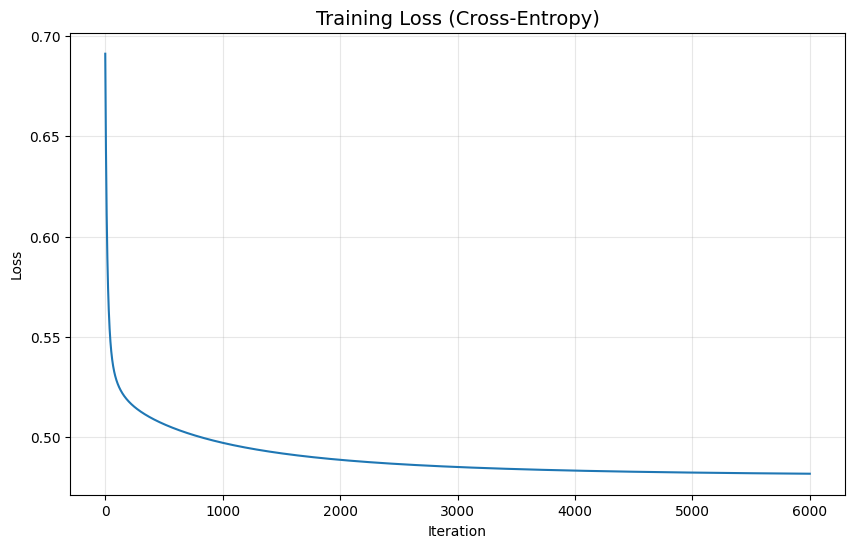

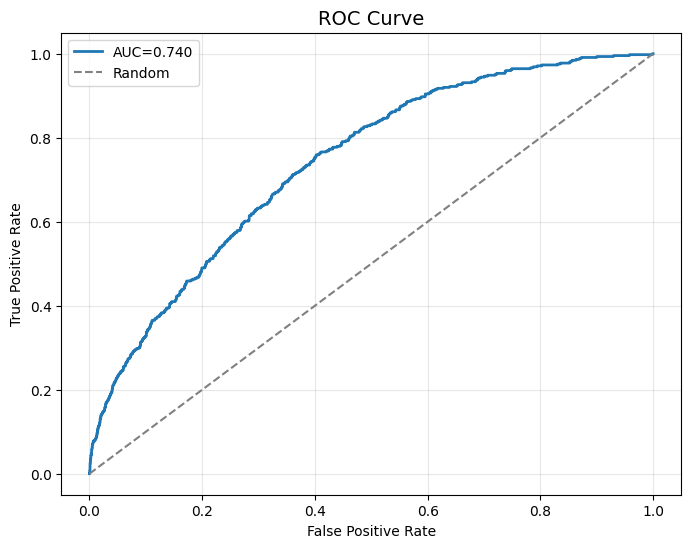

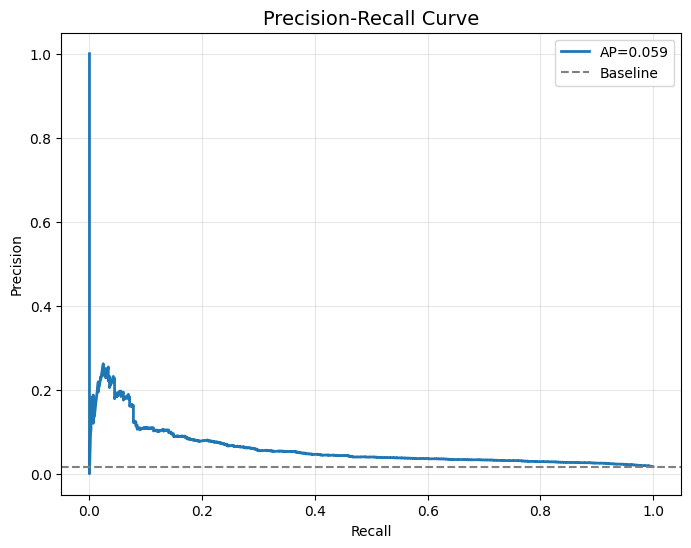

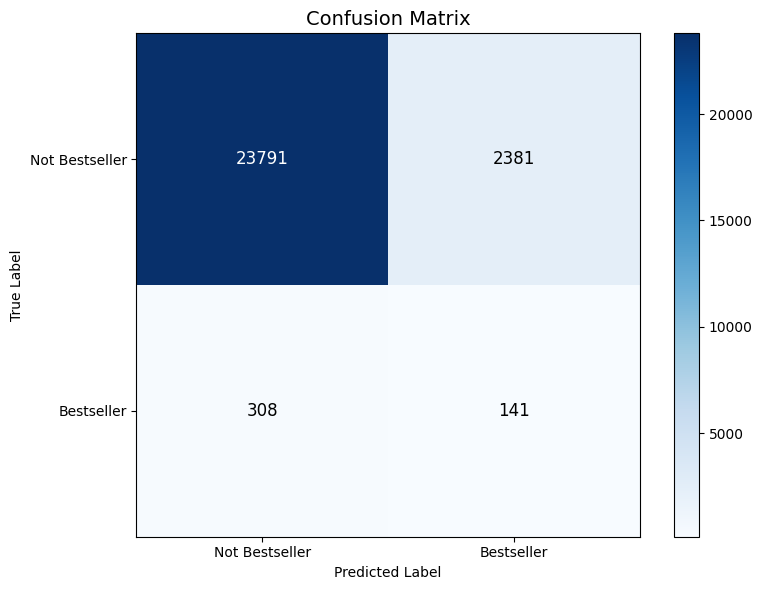

In [10]:
#Visualisations
import matplotlib.pyplot as plt

# Loss curve
plt.figure(figsize=(10, 6))
plt.plot(final_model.loss_history_)
plt.title("Training Loss (Cross-Entropy)", fontsize=14)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC={rocA:.3f}", linewidth=2)
plt.plot([0,1], [0,1], linestyle="--", color='gray', label='Random')
plt.title("ROC Curve", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Precision-Recall Curve
#Chugh, V. (2023).
#Precision-Recall Curve in Python Tutorial. [online] Datacamp.com.
#Available at: https://www.datacamp.com/tutorial/precision-recall-curve-tutorial.
#[Date Accessed: 26 October 2025]
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label=f"AP={ap:.3f}", linewidth=2)
plt.axhline(y=y_test.mean(), color='gray', linestyle='--', label='Baseline')
plt.title("Precision-Recall Curve", fontsize=14)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix", fontsize=14)
plt.colorbar()

# Axis labels
ticks = np.arange(2)
plt.xticks(ticks, ["Not Bestseller", "Bestseller"])
plt.yticks(ticks, ["Not Bestseller", "Bestseller"])

# Add numbers to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black",
                fontsize=12)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

**Feature importance:** This section analyses feature importance in the logistic regression model to understand which factors most strongly influence whether a book becomes a bestseller. It retrieves each feature’s coefficient, standard error, z-score, and p-value using the Wald test. These statistics show both the direction (positive or negative impact) and significance of each feature. The features are then ranked by the absolute size of their coefficients, highlighting the strongest predictors. Finally, a horizontal bar chart visualises the top 15 most important features, where green bars represent positive influence and red bars represent negative influence on bestseller likelihood.


Top 15 Most Important Features:


,feature,coefficient,std_err,z_value,p_value,abs_coef
19,primary_genre_limited_ohe_8,-1.794429,NaN,NaN,NaN,1.794429
1,num_0,-1.523668,NaN,NaN,NaN,1.523668
13,primary_genre_limited_ohe_2,1.422663,NaN,NaN,NaN,1.422663
17,primary_genre_limited_ohe_6,-1.129800,NaN,NaN,NaN,1.129800
31,primary_genre_limited_ohe_20,-0.968597,NaN,NaN,NaN,0.968597
30,primary_genre_limited_ohe_19,-0.941622,NaN,NaN,NaN,0.941622
34,primary_genre_limited_ohe_23,-0.875594,NaN,NaN,NaN,0.875594
32,primary_genre_limited_ohe_21,-0.846291,NaN,NaN,NaN,0.846291
36,primary_genre_limited_ohe_25,0.832596,NaN,NaN,NaN,0.832596
37,primary_genre_limited_ohe_26,-0.822836,NaN,NaN,NaN,0.822836


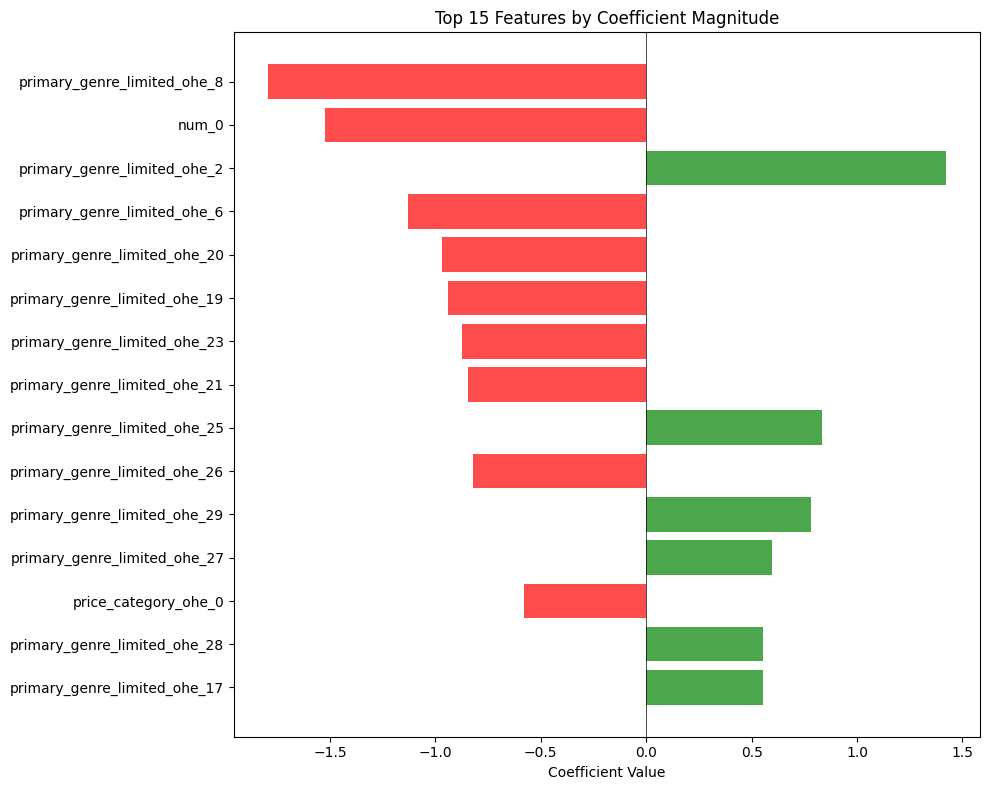

In [ ]:
#Feature Importance Analysis
#GeeksforGeeks (2024).
#Understanding Feature Importance in Logistic Regression Models. [online] GeeksforGeeks.
#Available at: https://www.geeksforgeeks.org/machine-learning/understanding-feature-importance-in-logistic-regression-models/.
#[Date Accessed: 26 October 2025]
import pandas as pd

# Get coefficients and p-values
se, z, pvals = final_model.wald_pvalues(X_train, y_train)
coef = final_model.w_.flatten()
names_full = ["intercept"] + feature_names

# Create summary DataFrame
summary = pd.DataFrame({
    "feature": names_full,
    "coefficient": coef,
    "std_err": se,
    "z_value": z,
    "p_value": pvals
})

# Calculate absolute coefficient for importance
summary["abs_coef"] = np.abs(summary["coefficient"])

# Sort by absolute coefficient (excluding intercept)
summary_features = summary[summary["feature"] != "intercept"].copy()
summary_features = summary_features.sort_values("abs_coef", ascending=False)

print("\nTop 15 Most Important Features:")
print("="*70)
display(summary_features.head(15))

# Visualise top features
top_n = 15
top_features = summary_features.head(top_n)

plt.figure(figsize=(10, 8))
colors = ['green' if c > 0 else 'red' for c in top_features['coefficient']]
plt.barh(range(top_n), top_features['coefficient'], color=colors, alpha=0.7)
plt.yticks(range(top_n), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title(f'Top {top_n} Features by Coefficient Magnitude')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Post processing using Threshold Analysis:** This section performs a threshold analysis to see how changing the decision threshold affects model performance. By testing many possible cutoff values between 0 and 1, it calculates precision, recall and F1-score for each threshold. These results are then plotted to show the trade-offs between metrics. The red line marks the previously selected optimal threshold. Finally, it prints a few examples of threshold values that achieve at least 40% recall or 15% precision, helping to choose a suitable operating point depending on the desired balance between false positives and false negatives.

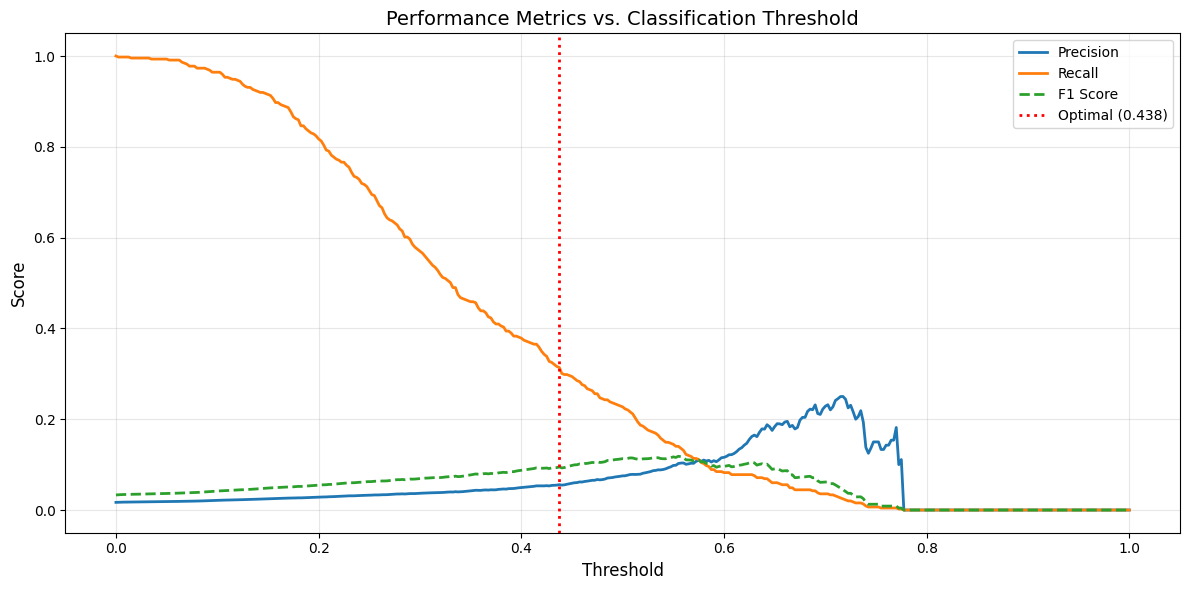


Threshold Analysis:

Recall >= 40%:


,threshold,precision,recall,f1
0,0.0000,0.016866,1.000000,0.033173
1,0.0025,0.017110,0.997773,0.033642
2,0.0050,0.017273,0.997773,0.033957
3,0.0075,0.017389,0.997773,0.034183
4,0.0100,0.017453,0.997773,0.034306



Precision >= 15%:


,threshold,precision,recall,f1
250,0.6250,0.155556,0.077951,0.103858
251,0.6275,0.162037,0.077951,0.105263
252,0.6300,0.165049,0.075724,0.103817
253,0.6325,0.161616,0.071269,0.098918
254,0.6350,0.171123,0.071269,0.100629


In [ ]:
#Threshold Analysis
#Harrison, G. (2021).
#Calculating and Setting Thresholds to Optimise Logistic Regression Performance | Towards Data Science. [online] Towards Data Science.
#Available at: https://towardsdatascience.com/calculating-and-setting-thresholds-to-optimise-logistic-regression-performance-c77e6d112d7e/.
‌#[Date Accessed: 26 October 2025]

#Function to test many threshold values
def sweep_thresholds(y_true, proba, grid=201):
    th = np.linspace(0, 1, grid)
    rows = []
    for t in th:
        y_hat = (proba >= t).astype(int)
        prec = precision_score(y_true, y_hat, zero_division=0)
        rec = recall_score(y_true, y_hat, zero_division=0)
        f1 = f1_score(y_true, y_hat, zero_division=0)
        rows.append((t, prec, rec, f1))
    return np.array(rows)

# Run sweep on test set
grid = sweep_thresholds(y_test, proba_test, grid=401)
sweep_df = pd.DataFrame(grid, columns=["threshold","precision","recall","f1"]).sort_values("threshold")

# Visualise threshold trade-offs
plt.figure(figsize=(12, 6))
plt.plot(sweep_df["threshold"], sweep_df["precision"], label="Precision", linewidth=2)
plt.plot(sweep_df["threshold"], sweep_df["recall"], label="Recall", linewidth=2)
plt.plot(sweep_df["threshold"], sweep_df["f1"], label="F1 Score", linewidth=2, linestyle='--')
plt.axvline(x=best_thresh, color='red', linestyle=':', label=f'Optimal ({best_thresh:.3f})', linewidth=2)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Performance Metrics vs. Classification Threshold", fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Show key threshold points
print("\nThreshold Analysis:")
print("="*70)
print("\nRecall >= 40%:")
display(sweep_df[sweep_df["recall"] >= 0.40].head(5))
print("\nPrecision >= 15%:")
display(sweep_df[sweep_df["precision"] >= 0.15].head(5))